In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import data_tools.graphs as gt
from hetnet_ml.extractor import MatrixFormattedGraph

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
man_dir = Path('../0_data/manual/').resolve()
load_dir = Path('../2_pipeline/11a_Model_Prep_Holdout_Set/out/').resolve()

In [3]:
nodes = pd.read_csv(load_dir.joinpath('nodes.csv'), dtype=str)
edges = pd.read_csv(load_dir.joinpath('edges.csv'), dtype=str)

In [4]:
nodes.head(2)

,id,name,label,xrefs,source
0,UBERON:0000002,cervix,AnatomicalEntity,MESH:D002584|UBERON:0000002,NaN
1,UBERON:0000004,human nose,AnatomicalEntity,MESH:D009666|UBERON:0000004,NaN


In [5]:
edges['type'].nunique()

96

In [6]:
mps = gt.dataframes_to_metagraph(nodes, edges).extract_metapaths('ChemicalSubstance', 'Disease', 4)
mps = [mp for mp in mps if len(mp) > 1]
len(mps)

29641

In [7]:
mps = [mp for mp in mps if len(mp) > 1]

In [8]:
mps[0]

CaAawD

In [9]:
e_info = pd.read_csv(man_dir.joinpath('edge_semtypes.csv'))
directed_map = e_info.set_index('fwd_edge')['directed']

In [10]:
similarity_paths_check = []

for mp in tqdm(mps):
    if len(mp) < 2:
        similarity_paths_check.append(True)
        continue
    this_path = []
    for label in ['ChemicalSubstance']:
        this_path.append(gt.is_similarity(mp, ['ChemicalSubstance'], directed_map))
    this_path.append(gt.is_similarity(mp, 'Disease', directed_map, max_repeats=1))
    
    # Don't want CtXaYzD edges.. Ct (and Cm) edges should be banned...
    # Though not strictly similarity edges, they have heavy implications for Disease Phenotype similarity
    bl_edge = ['Ct', 'Cm', 'Cdg', 'Cpl', 'Cpv']
    for bl in bl_edge:
        if mp.abbrev.startswith(bl) or mp.abbrev.endswith('aw'+bl+'D'):
            this_path.append(True)
    
    similarity_paths_check.append(sum(this_path) > 0)

In [11]:
non_sim_mps = [mp for mp, sim in zip(mps, similarity_paths_check) if not sim]
len(non_sim_mps)

13158

## Routine for extracting information

In [13]:
from copy import deepcopy

def piecewise_extraction(function, to_split, block_size=1000, **params):
    
    assert type(to_split) == str and to_split in params
    
    # Won't want progress bars for each subsetx
    params['verbose'] = False
    
    # Retain a copy of the original parameters
    full_params = deepcopy(params)    
    total = len(params[to_split])
    
    # Determine the number of iterations needed
    num_iter = total // block_size
    if total % block_size != 0:
        num_iter += 1
    
    all_results = []
    for i in tqdm(range(num_iter)):
        
        # Get the start and end indicies
        start = i * block_size
        end = (i+1) * block_size
        
        # End can't be larger than the total number items
        if end > total:
            end = total
        
        # Subset the paramter of interest
        params[to_split] = full_params[to_split][start: end]
        
        # Get the funciton results
        all_results.append(function(**params))
    
    return pd.concat(all_results, sort=False, ignore_index=True)

In [14]:
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=0.4, n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 96/96 [02:02<00:00,  1.28s/it]



Determining degrees for each node and metaedge


100%|██████████| 96/96 [00:31<00:00,  3.06it/s]



Weighting matrices by degree with dampening factor 0.4...


100%|██████████| 96/96 [00:01<00:00, 49.73it/s]


# Memory requirement estimates

## Estimate on memory required to extract all Compound-Disease Pairs

In [15]:
float_size = 32 # bits
bits_per_gb = 8589934592

def print_mem_info(n_comp, n_dis, n_mps):
    print("{:,} Compounds * {:,} Diseases = {:,} C-D Pairs".format(n_comp, n_dis,
                                                                   n_comp * n_dis))
    print("{:,} C-D Pairs * {:,} Metapaths = {:,} Matrix Values".format(n_comp * n_dis,
                                                                    n_mps, 
                                                                    n_comp * n_dis * n_mps))

    print('{:1,.1f} GB of matrix values'.format(n_comp * n_dis * n_mps * float_size / (bits_per_gb)))
    
    print('{:1,.3f} GB per metapath'.format(n_comp * n_dis * float_size / (bits_per_gb)))

In [16]:
total_comps = nodes['label'].value_counts()['ChemicalSubstance']
total_dis = nodes['label'].value_counts()['Disease']


print_mem_info(total_comps, total_dis, len(non_sim_mps))

31,947 Compounds * 15,696 Diseases = 501,440,112 C-D Pairs
501,440,112 C-D Pairs * 11,443 Metapaths = 5,737,979,201,616 Matrix Values
21,375.6 GB of matrix values
1.868 GB per metapath


In [17]:
%%time
all_mp_counts = []

mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=200,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes='ChemicalSubstance', 
                                 end_nodes='Disease', 
                                 n_jobs=30)

mp_counts['subset'] = 'all_pairs'
mp_counts['frac'] = mp_counts['pair_count'] / (total_comps*total_dis)
all_mp_counts.append(mp_counts)


CPU times: user 31min 47s, sys: 8min 26s, total: 40min 13s
Wall time: 1h 49min 32s


In [18]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CaAawD,19950,all_pairs,0.00004
1,CaAsoD,0,all_pairs,0.00000


In [19]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 61.66%'

## All potential training Positives

In [20]:
keep_comps = set(edges.query('type == "treats_CtD"')['start_id'])
keep_dis = set(edges.query('type == "treats_CtD"')['end_id'])

print_mem_info(len(keep_comps), len(keep_dis), len(non_sim_mps))

8,377 Compounds * 5,615 Diseases = 47,036,855 C-D Pairs
47,036,855 C-D Pairs * 11,443 Metapaths = 538,242,731,765 Matrix Values
2,005.1 GB of matrix values
0.175 GB per metapath


In [21]:
%%time
mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=500,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes=list(keep_comps), 
                                 end_nodes=list(keep_dis), 
                                 n_jobs=30)

mp_counts['subset'] = 'all_pos'
mp_counts['frac'] = mp_counts['pair_count'] / (len(keep_comps)*len(keep_dis))
all_mp_counts.append(mp_counts)


CPU times: user 19min 30s, sys: 4min 2s, total: 23min 33s
Wall time: 55min 52s


In [22]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CaAawD,8222,all_pos,0.000175
1,CaAsoD,0,all_pos,0.000000


In [23]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 58.25%'

## Reframe Compounds and Reframe Treated Diseases



In [24]:
ref_c = nodes.dropna(subset=['source'])['id'].tolist()
len(ref_c)

5988

In [25]:
keep_comps = set(ref_c)
keep_dis = set(edges.query('start_id in @ref_c and type == "treats_CtD"')['end_id'])

print_mem_info(len(keep_comps), len(keep_dis), len(non_sim_mps))

5,988 Compounds * 5,099 Diseases = 30,532,812 C-D Pairs
30,532,812 C-D Pairs * 11,443 Metapaths = 349,386,967,716 Matrix Values
1,301.6 GB of matrix values
0.114 GB per metapath


In [26]:
%%time
mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=1000,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes=list(keep_comps), 
                                 end_nodes=list(keep_dis), 
                                 n_jobs=30)

mp_counts['subset'] = 'reframe'
mp_counts['frac'] = mp_counts['pair_count'] / (len(keep_comps)*len(keep_dis))
all_mp_counts.append(mp_counts)


CPU times: user 10min 21s, sys: 2min 28s, total: 12min 50s
Wall time: 42min 23s


In [27]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CaAawD,5217,reframe,0.000171
1,CaAsoD,0,reframe,0.000000


In [28]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 53.37%'

## Ideal Training Subset

Ideally we need all compounds and diseases associated with training positives, as well as some negatives.

In [29]:
neg_frac = 0.1
rs = 1234


keep_comps = set(edges.query('type == "treats_CtD"')['start_id'])
keep_comps = (keep_comps | set(nodes.query('id not in @keep_comps and label == "ChemicalSubstance"')
                                    .sample(frac=neg_frac, random_state=rs)['id']))

keep_dis =  set(edges.query('type == "treats_CtD"')['end_id'])
keep_dis = (keep_dis | set(nodes.query('label == "Disease" and id not in @keep_dis')
                                .sample(frac=neg_frac, random_state=rs+1)['id']))

In [30]:
print_mem_info(len(keep_comps), len(keep_dis), len(non_sim_mps))

10,734 Compounds * 6,623 Diseases = 71,091,282 C-D Pairs
71,091,282 C-D Pairs * 11,443 Metapaths = 813,497,539,926 Matrix Values
3,030.5 GB of matrix values
0.265 GB per metapath


In [31]:
%%time
mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=1000,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes=list(keep_comps), 
                                 end_nodes=list(keep_dis), 
                                 n_jobs=30)

mp_counts['subset'] = 'traning_sample'
mp_counts['frac'] = mp_counts['pair_count'] / (len(keep_comps)*len(keep_dis))
all_mp_counts.append(mp_counts)


CPU times: user 12min 12s, sys: 2min 44s, total: 14min 57s
Wall time: 48min 52s


In [32]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CaAawD,8572,traning_sample,0.000121
1,CaAsoD,0,traning_sample,0.000000


In [33]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 58.67%'

##  All Training Negatives

Lastly, lets take a look at all of the potnetial training negatives.  As these are compounds or diseases with no known treatments, its likely that there will be less informaiton known about them

In [34]:
pos_comps = set(edges.query('type == "treats_CtD"')['start_id'])
pos_dis = set(edges.query('type == "treats_CtD"')['end_id'])

neg_comps = set(nodes.query('label == "ChemicalSubstance"')['id']) - pos_comps
neg_dis = set(nodes.query('label == "Disease"')['id']) - pos_dis

print_mem_info(len(neg_comps), len(neg_dis), len(non_sim_mps))

23,570 Compounds * 10,081 Diseases = 237,609,170 C-D Pairs
237,609,170 C-D Pairs * 11,443 Metapaths = 2,718,961,732,310 Matrix Values
10,128.9 GB of matrix values
0.885 GB per metapath


In [35]:
%%time
mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=350,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes=list(neg_comps), 
                                 end_nodes=list(neg_dis), 
                                 n_jobs=30)

mp_counts['subset'] = 'negative_pairs'
mp_counts['frac'] = mp_counts['pair_count'] / (len(keep_comps)*len(keep_dis))
all_mp_counts.append(mp_counts)


CPU times: user 24min 3s, sys: 4min 41s, total: 28min 45s
Wall time: 57min 59s


In [36]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CaAawD,2069,negative_pairs,0.000029
1,CaAsoD,0,negative_pairs,0.000000


In [37]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 48.19%'

## Plot some of the results

In [38]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from data_tools.plotting import count_plot_h

In [39]:
non_sim_mp_names = [mp.abbrev for mp in non_sim_mps]

all_mp_counts = pd.concat(all_mp_counts, sort=False, ignore_index=True)
all_mp_counts['sim_mp'] = all_mp_counts['mp'].apply(lambda m: m not in non_sim_mp_names)

no_sim_mp_counts = all_mp_counts.query('sim_mp == False')
sim_mp_counts = all_mp_counts.query('sim_mp == True')

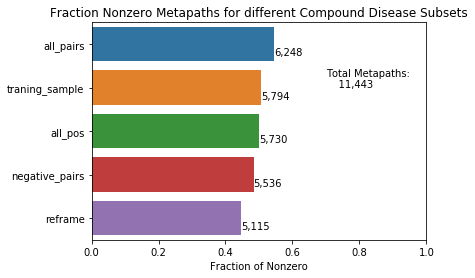

In [40]:
qr = no_sim_mp_counts.query('pair_count > 0')
frac = qr['subset'].value_counts() / no_sim_mp_counts['mp'].nunique()

count_plot_h(frac, qr['subset'].value_counts())
plt.xlim(0, 1)
plt.xlabel('Fraction of Nonzero')
plt.annotate('Total Metapaths:\n    {:,}'.format(no_sim_mp_counts['mp'].nunique()), (.7, 1))
plt.title('Fraction Nonzero Metapaths for different Compound Disease Subsets');

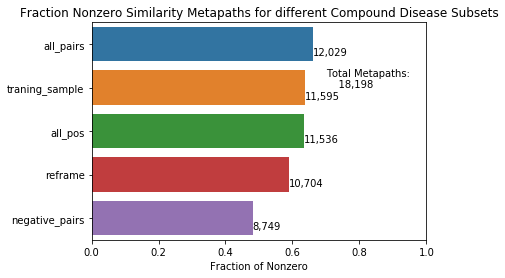

In [41]:
qr = sim_mp_counts.query('pair_count > 0')
frac = qr['subset'].value_counts() / sim_mp_counts['mp'].nunique()

count_plot_h(frac, qr['subset'].value_counts())
plt.xlim(0, 1)
plt.xlabel('Fraction of Nonzero')
plt.annotate('Total Metapaths:\n    {:,}'.format(sim_mp_counts['mp'].nunique()), (.7, 1))
plt.title('Fraction Nonzero Similarity Metapaths for different Compound Disease Subsets');

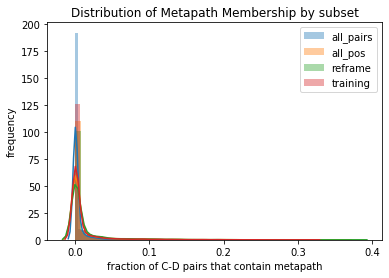

In [42]:
sns.distplot((no_sim_mp_counts.query('subset == "all_pairs" and frac > 0')['frac']), label='all_pairs');
sns.distplot((no_sim_mp_counts.query('subset == "all_pos" and frac > 0')['frac']), label='all_pos');
sns.distplot((no_sim_mp_counts.query('subset == "reframe" and frac > 0')['frac']), label='reframe');
sns.distplot((no_sim_mp_counts.query('subset == "traning_sample" and frac > 0')['frac']), label='training')
plt.legend()
plt.xlabel('fraction of C-D pairs that contain metapath')
plt.ylabel('frequency')
plt.title('Distribution of Metapath Membership by subset');

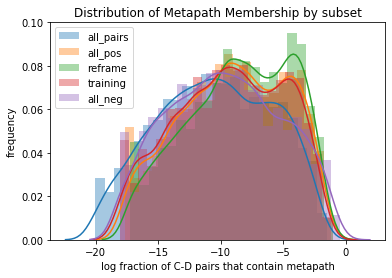

In [43]:
sns.distplot(np.log(no_sim_mp_counts.query('subset == "all_pairs" and frac > 0')['frac']), label='all_pairs');
sns.distplot(np.log(no_sim_mp_counts.query('subset == "all_pos" and frac > 0')['frac']), label='all_pos');
sns.distplot(np.log(no_sim_mp_counts.query('subset == "reframe" and frac > 0')['frac']), label='reframe');
sns.distplot(np.log(no_sim_mp_counts.query('subset == "traning_sample" and frac > 0')['frac']), label='training')
sns.distplot(np.log(no_sim_mp_counts.query('subset == "negative_pairs" and frac > 0')['frac']), label='all_neg')

plt.legend()
plt.xlabel('log fraction of C-D pairs that contain metapath')
plt.ylabel('frequency')
plt.title('Distribution of Metapath Membership by subset');

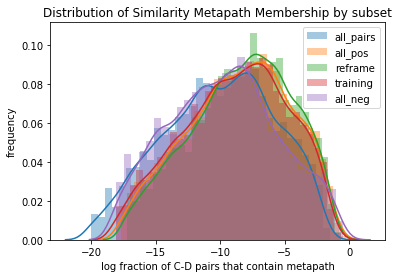

In [44]:
sns.distplot(np.log(sim_mp_counts.query('subset == "all_pairs" and frac > 0')['frac']), label='all_pairs');
sns.distplot(np.log(sim_mp_counts.query('subset == "all_pos" and frac > 0')['frac']), label='all_pos');
sns.distplot(np.log(sim_mp_counts.query('subset == "reframe" and frac > 0')['frac']), label='reframe');
sns.distplot(np.log(sim_mp_counts.query('subset == "traning_sample" and frac > 0')['frac']), label='training')
sns.distplot(np.log(sim_mp_counts.query('subset == "negative_pairs" and frac > 0')['frac']), label='all_neg')
plt.legend()
plt.xlabel('log fraction of C-D pairs that contain metapath')
plt.ylabel('frequency')
plt.title('Distribution of Similarity Metapath Membership by subset');

In [45]:
all_mp_counts.query('subset == "all_pairs"').sort_values('frac', ascending=False).head()

,mp,pair_count,subset,frac,sim_mp
16248,CinGmDawBPawD,111130382,all_pairs,0.221622,True
16603,CinGmPawBPawD,108829531,all_pairs,0.217034,False
16033,CinGaCinBPawD,103574013,all_pairs,0.206553,True
16119,CinGinCinBPawD,103467977,all_pairs,0.206342,True
16031,CinGaCaBPawD,101548940,all_pairs,0.202515,True


In [46]:
no_sim_mp_counts.query('subset == "all_pairs"').sort_values('frac', ascending=False).head()

,mp,pair_count,subset,frac,sim_mp
16603,CinGmPawBPawD,108829531,all_pairs,0.217034,False
19172,CawPWawPawBPawD,100645650,all_pairs,0.200713,False
19050,CawPWpoGiBPawD,98112950,all_pairs,0.195662,False
13701,CaGmPawBPawD,97052416,all_pairs,0.193547,False
16599,CinGmPawAawD,91545480,all_pairs,0.182565,False


In [47]:
all_mp_counts.query('subset == "all_pos"').sort_values('frac', ascending=False).head()

,mp,pair_count,subset,frac,sim_mp
41748,CtDawBPaCtD,37356226,all_pos,0.794191,True
41758,CtDawBPinCtD,37235583,all_pos,0.791626,True
42204,CtDawPWawCtD,37051489,all_pos,0.787712,True
41753,CtDawBPafCtD,34094275,all_pos,0.724842,True
42082,CtDmGaCtD,29885271,all_pos,0.635359,True


In [48]:
no_sim_mp_counts.query('subset == "all_pos"').sort_values('frac', ascending=False).head()

,mp,pair_count,subset,frac,sim_mp
46244,CinGmPawBPawD,16737877,all_pos,0.355846,False
45467,CinGiBPawPpsD,12818087,all_pos,0.272512,False
46203,CinGawPawBPawD,12691519,all_pos,0.269821,False
43342,CaGmPawBPawD,12650832,all_pos,0.268956,False
46240,CinGmPawAawD,12582889,all_pos,0.267511,False


## Save out the information

In [49]:
this_file = '11b_Model_Prep_Metapath_Membership_Analysis'

out_dir = Path('../2_pipeline').joinpath(this_file).joinpath('out').resolve()
out_dir.mkdir(exist_ok=True, parents=True)

In [50]:
all_mp_counts.to_csv(out_dir.joinpath('all_mp_counts.csv'), index=False)